# Todo
## do it in mnist digits dataset
- [x] load dataset
- [x] implement paper in code.
- [x] train from scratch for a few epochs supervised(training)
- [x] viz loss and gradients to see if the training is approaching a minima or not
- [x] viz learned positional embedding
- [x] viz attn map for few images
- [ ] viz attention distance as in paper
- [ ] viz amount of compute for inference and inference speed.
- [ ] perform ablation study
- [ ] load weights from pretrained
- [ ] finetune for 2 class classification. (2 class plus 1 unknown) on higher resolution
- [ ] viz clustering effect of vit in 2 classes
- [ ] do everything by doing self supervised training. mae, jepa(optional)
- [ ] distill this in smaller model
- [ ] use synthetic data to make it better
- [ ]  Adversarial robustness in computer vision models in ViT project




# Loading MNIST digit dataset

https://huggingface.co/datasets/ylecun/mnist

In [ ]:
!pip install -q datasets

In [ ]:
from datasets import load_dataset

ds = load_dataset("ylecun/mnist")
ds

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 60000
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 10000
    })
})

In [ ]:
from torch.utils.data import DataLoader
import torch
from torchvision import transforms

to_tensor = transforms.ToTensor()
def transform(batch):
  batch["image"] = [(to_tensor(img)) for img in batch["image"]]
  return batch

ds.set_transform(transform) # it does the transformation when loading the data later during training and testing
# ds.map(transform, batched = True)# it transforms the whole dataset upfront. takes too long

In [ ]:
split_ds = ds["train"].train_test_split(test_size=0.1, shuffle=True, seed=42)
train_ds = split_ds["train"]
val_ds = split_ds["test"]
test_ds = ds["test"]

In [ ]:
one_data = next(iter(ds["train"]))
print(one_data["label"])
print(one_data["image"].shape)
print(type(one_data["image"]))


5
torch.Size([1, 28, 28])
<class 'torch.Tensor'>


In [ ]:
BATCH_SIZE = 64

In [100]:
train_loader = DataLoader(train_ds, batch_size=1, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE)
test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE)

In [ ]:
one_image = next(iter(train_loader))["image"][0]
print(one_image.shape)

torch.Size([1, 28, 28])


# Vision Transformer implementation
src: http://arxiv.org/abs/2010.11929
##An Image is Worth 16x16 Words
https://github.com/google-research/vision_transformer

In [ ]:
P = 4 #patch size
C = 1
H = 28
W = 28
N = int(H * W / P**2)
print(f"Number of patches: {N}, patch size: {P}")

Number of patches: 49, patch size: 4


In [ ]:
from torch import nn

class MakePatches(nn.Module):
  def __init__(self, patch_size=P):
    super().__init__()
    self.patch_size = patch_size
    self.unfold = nn.Unfold(kernel_size=patch_size, stride=patch_size)

  def forward(self, x):
    b, c, h, w = x.shape
    x = self.unfold(x)#B,(c*p*p), n.   n = no .f patches
    # x = x.view(b, c, self.patch_size, self.patch_size, -1).permute(0, 4, 1, 2, 3)#b,n,c,p,p
    x = x.view(b, -1, C*P*P)
    return x

  def viz(self, x):
    b, c, h, w = x.shape
    x = self.unfold(x)#B,(c*p*p), n.   n = no .f patches
    x = x.view(b, c, self.patch_size, self.patch_size, -1).permute(0, 4, 1, 2, 3)#b,n,c,p,p
    return x



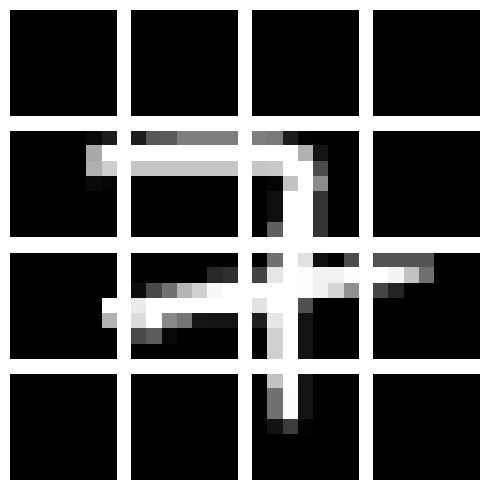

In [ ]:
import matplotlib.pyplot as plt
patch_maker = MakePatches(patch_size=7)

batch = next(iter(train_loader))
images, labels = batch["image"], batch["label"]


patches = patch_maker.viz(images)


first_image_patches = patches[0]


def show_patches(patches, n_rows=4, n_cols=4):
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(5, 5))

    for idx, patch in enumerate(first_image_patches):
        row, col = divmod(idx, n_rows)
        axes[row, col].imshow(patch.permute(1, 2, 0), cmap="gray")  # Rearrange (C, H, W) -> (H, W, C)
        axes[row, col].axis("off")

    plt.tight_layout()
    plt.show()

show_patches(first_image_patches)

https://github.com/karpathy/nanoGPT

In [ ]:
class LayerNorm(nn.Module):
  """We are creating our own custom layernorm because pytorch's implementation does not allow use to do bias=False"""
  def __init__(self, ndim, bias=False):
    super().__init__()
    self.weight = nn.Parameter(torch.ones(ndim))
    self.bias = nn.Parameter(torch.zeros(ndim)) if bias else None

  def forward(self, x):
    return nn.functional.layer_norm(x,self.weight.shape, self.weight, self.bias, 1e-5)


# norm = LayerNorm(16)
# norm(torch.rand((64, 32, 16))).shape

in multihead attention, we project the input to have 3 times the input dims(channel),
split to k, q, v
then divide channel to all the heads, so each k q v act in a subset of channels. then we aggregate


In [68]:
attention_maps = []

In [69]:
import math
from torch.nn import functional as F


class MultiHeadSelfAttention(nn.Module):
  def __init__(self, n_heads, n_embd, dropout=0.2, bias=False):
    super().__init__()
    assert n_embd % n_heads == 0
    self.n_heads = n_heads
    self.n_embd = n_embd
    self.dropout = dropout
    self.bias = bias
    self.c_attn = nn.Linear(n_embd, 3*n_embd, bias=bias)
    self.c_proj = nn.Linear(n_embd, n_embd, bias=bias)
    self.resid_dropout = nn.Dropout(dropout)

  def forward(self, x, mask=None, is_causal=False):
    B, T, C = x.shape
    k, q, v = self.c_attn(x).split(self.n_embd, dim=2)
    k = k.view(B, T, self.n_heads, C//self.n_heads).transpose(1,2)# (B, nh, T, hs); hs= head size = no of channels in each head; nh=number of head
    q = q.view(B, T, self.n_heads, C//self.n_heads).transpose(1,2)
    v = v.view(B, T, self.n_heads, C//self.n_heads).transpose(1,2)
    # flash attn gpu brrrrrrrrr for training
    # y = nn.functional.scaled_dot_product_attention(q,k,v, attn_mask=mask, dropout_p=self.dropout if self.training else 0, is_causal=is_causal)


    #fro viz only
    scale_factor = 1 / math.sqrt(q.size(-1))
    attention_weight = q @ k.transpose(-2, -1) * scale_factor
    # todo code to accept mask
    y = F.softmax(attention_weight, dim=-1)#ignored dropout as well here
    y = y @ v
    global attention_maps
    attention_maps.append(attention_weight.detach().cpu())
    y = y.transpose(1, 2).contiguous().view(B, T, C) # re-assemble all head outputs side by side
    y = self.resid_dropout((self.c_proj(y)))
    return y


# mha = MultiHeadSelfAttention(8, 16, 0.4)
# mha(torch.rand((64, 32, 16))).shape


In [ ]:
class MLP(nn.Module):
  def __init__(self, n_embd, dropout=0.2, bias=False):
    super().__init__()
    self.c_fc = nn.Linear(n_embd, 4*n_embd, bias=bias)
    self.c_proj = nn.Linear(4*n_embd, n_embd, bias=bias)
    self.dropout = nn.Dropout(dropout)
    self.gelu = nn.GELU()

  def forward(self, x):
    x = self.c_fc(x)
    x = self.gelu(x)
    x = self.c_proj(x)
    x = self.dropout(x)
    return x



In [ ]:
class Block(nn.Module):
  def __init__(self, n_embd, n_heads, dropout=0.2, bias=False):
    super().__init__()
    self.ln1 = LayerNorm(n_embd)
    self.ln2 = LayerNorm(n_embd)
    self.attn = MultiHeadSelfAttention(n_heads, n_embd, dropout, bias)
    self.mlp = MLP(n_embd, dropout, bias)

  def forward(self, x, mask=None):
    x = x + self.attn(self.ln1(x), mask)
    x = x + self.mlp(self.ln2(x))
    return x


https://tintn.github.io/Implementing-Vision-Transformer-from-Scratch/

In [59]:
class VisionTransformer(nn.Module):
  def __init__(self, n_patches, n_embd, n_blocks, n_heads, bias=False, dropout=0.2):#block size is the context size which is just the number of patches here
    super().__init__()
    self.n_patches = n_patches
    self.n_embed = n_embd
    self.n_heads = n_heads
    self.bias = bias
    self.dropout = dropout

    self.patch_embd_proj = nn.Linear(C*P*P, n_embd, bias=bias)
    self.cls_token = nn.Parameter(torch.randn(1, 1, n_embd))
    self.positional_embd = nn.Parameter(torch.randn(1, N+1, n_embd))

    self.patch_maker = MakePatches()
    self.blocks = nn.ModuleList([Block(n_embd, n_heads, dropout, bias) for _ in range(n_blocks)])

  def forward(self, x, mask=None):
    x = self.patch_maker(x)
    # print("patch", x.shape)
    x = self.patch_embd_proj(x)
    cls_tokens = self.cls_token.expand(x.shape[0], -1, -1)#expand for each data in a batch
    # print("cls", cls_tokens.shape)
    # print("patch embd ", x.shape)
    x = torch.cat((cls_tokens, x), dim=1)#prepend to each data
    # print("cat", x.shape)
    # print("pos", self.positional_embd.shape)
    x = x + self.positional_embd
    for block in self.blocks:
      x = block(x, mask)
    return x




vit = VisionTransformer(49, 128, 8, 8)
vit(torch.randn((64, 1, 28, 28))).shape

torch.Size([64, 50, 128])

In [60]:
class VisionTransformerForClassificaiton(nn.Module):
  def __init__(self,n_classes = 10):
    super().__init__()
    self.vit = VisionTransformer(49, 128, 8, 8)
    self.head = nn.Linear(128, n_classes)

  def forward(self, x):
    x = self.vit(x)
    cls = x[:, 0]
    logits = self.head(cls)
    return logits


In [ ]:
!pip install -q wandb

"330a4a0723c3988c8d367cbb822d3d6624621fbd"

In [ ]:
import wandb

api_key = "330a4a0723c3988c8d367cbb822d3d6624621fbd"
wandb.login(key=api_key)

# training classifier from scratch

In [ ]:
# name = str(input("Enter run name: "))
# wandb.init(project="vit-implementation", name=f"{name}")

# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# model = VisionTransformerForClassificaiton().to(device)

# if torch.cuda.device_count() > 1:
#   print(f"using {torch.cuda.device_count()} gpus")
#   model = nn.DataParallel(model)

# optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)
# criterion = nn.CrossEntropyLoss()

# epochs = 20
# for epoch in range(epochs):
#     # Training step
#     model.train()
#     train_loss = 0
#     total_norm = 0
#     for batch_idx, train_data in enumerate(train_loader):
#         data, target = train_data["image"].to(device), train_data["label"].to(device)
#         optimizer.zero_grad()
#         output = model(data)
#         loss = criterion(output, target)
#         loss.backward()

#         # Compute gradient norm
#         total_norm = 0
#         for param in model.parameters():
#             if param.grad is not None:
#                 param_norm = param.grad.data.norm(2)
#                 total_norm += param_norm.item() ** 2
#         total_norm = total_norm ** 0.5

#         optimizer.step()
#         train_loss += loss.item()

#     train_loss /= len(train_loader)

#     # Validation step
#     model.eval()
#     val_loss = 0
#     with torch.no_grad():
#         for val_data in val_loader:
#             data, target = val_data["image"].to(device), val_data["label"].to(device)
#             output = model(data)
#             val_loss += criterion(output, target).item()

#     val_loss /= len(val_loader)

#     wandb.log({
#         "Epoch": epoch,
#         "Train Loss": train_loss,
#         "Validation Loss": val_loss,
#         "Gradient Norm": total_norm,
#         "GPU Usage (MB)": torch.cuda.memory_allocated(device) / (1024 * 1024)
#     })

#     # Print progress
#     print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, ",
#           f"Val Loss: {val_loss:.4f}, Grad Norm: {total_norm:.4f}")

# wandb.finish()



Enter run name: lr_1e-3_epoch_20_128_8_8

- 128 8 8 n_embd n_block n_head

image (1, 28, 28)
image (1, 28, 28)
image (1, 28, 28)
image (1, 28, 28)
image (1, 28, 28)


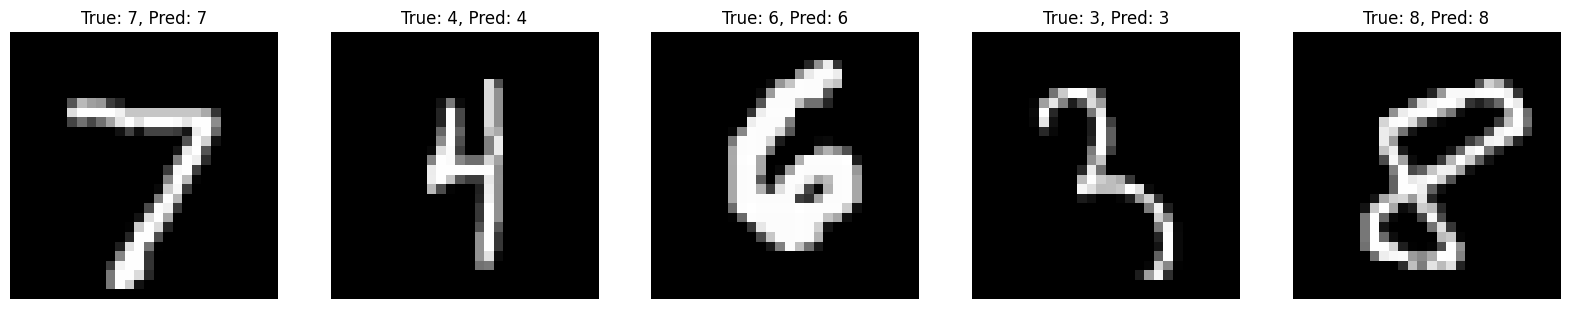

Test Loss: 0.0717


In [126]:
# import matplotlib.pyplot as plt
# import numpy as np
criterion = nn.CrossEntropyLoss()
model.eval()  # Set model to evaluation mode
test_loss = 0.0

with torch.no_grad():
    fig, axes = plt.subplots(1, 5, figsize=(20, 4))  # Display 5 images
    for idx, test_data in enumerate(test_loader):
        data, target = test_data["image"].to(device), test_data["label"].to(device)
        output = model(data)
        test_loss += criterion(output, target).item()

        # Get predictions
        _, pred = output.max(1)

        # Visualize only the first 5 samples
        if idx < 5:
            img = data[idx].cpu().numpy()
            print(f"image {img.shape}")
            img = np.transpose(img, (1, 2, 0))  # Reorder dimensions for visualization

            axes[idx].imshow(img,cmap="grey")
            axes[idx].set_title(f"True: {target[idx].item()}, Pred: {pred[idx].item()}")
            axes[idx].axis('off')

    plt.show()

test_loss /= len(test_loader)
print(f"Test Loss: {test_loss:.4f}")



In [61]:
from google.colab import drive
drive.mount('/content/drive')

# torch.save(model.state_dict(), '/content/drive/MyDrive/research/lr_1e-3_epoch_20_128_8_8.pth')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# loading the saved checkpoints for further analysis

In [70]:

model = VisionTransformerForClassificaiton()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = VisionTransformerForClassificaiton().to(device)
checkpoint_path = "/content/drive/MyDrive/research/lr_1e-3_epoch_20_128_8_8.pth"
model.load_state_dict(torch.load(checkpoint_path, map_location=torch.device('cpu')))
model.eval()
if torch.cuda.device_count() > 1:
  print(f"using {torch.cuda.device_count()} gpus")
  model = nn.DataParallel(model)

model(torch.randn((1, 1, 28, 28))).shape


<ipython-input-70-1e8921a48af2>:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(checkpoint_path, map_location=torch.device('cpu')))


torch.Size([1, 10])

In [63]:
print(f"total paramerters = {sum(p.numel() for p in model.parameters())}")
for name, param in model.named_parameters():
    print(f"Layer: {name} | Shape: {param.shape} | Requires Grad: {param.requires_grad}")


total paramerters = 1584778
Layer: vit.cls_token | Shape: torch.Size([1, 1, 128]) | Requires Grad: True
Layer: vit.positional_embd | Shape: torch.Size([1, 50, 128]) | Requires Grad: True
Layer: vit.patch_embd_proj.weight | Shape: torch.Size([128, 16]) | Requires Grad: True
Layer: vit.blocks.0.ln1.weight | Shape: torch.Size([128]) | Requires Grad: True
Layer: vit.blocks.0.ln2.weight | Shape: torch.Size([128]) | Requires Grad: True
Layer: vit.blocks.0.attn.c_attn.weight | Shape: torch.Size([384, 128]) | Requires Grad: True
Layer: vit.blocks.0.attn.c_proj.weight | Shape: torch.Size([128, 128]) | Requires Grad: True
Layer: vit.blocks.0.mlp.c_fc.weight | Shape: torch.Size([512, 128]) | Requires Grad: True
Layer: vit.blocks.0.mlp.c_proj.weight | Shape: torch.Size([128, 512]) | Requires Grad: True
Layer: vit.blocks.1.ln1.weight | Shape: torch.Size([128]) | Requires Grad: True
Layer: vit.blocks.1.ln2.weight | Shape: torch.Size([128]) | Requires Grad: True
Layer: vit.blocks.1.attn.c_attn.weight

# Visualization Positional Embedding reference
https://arxiv.org/abs/2305.07011

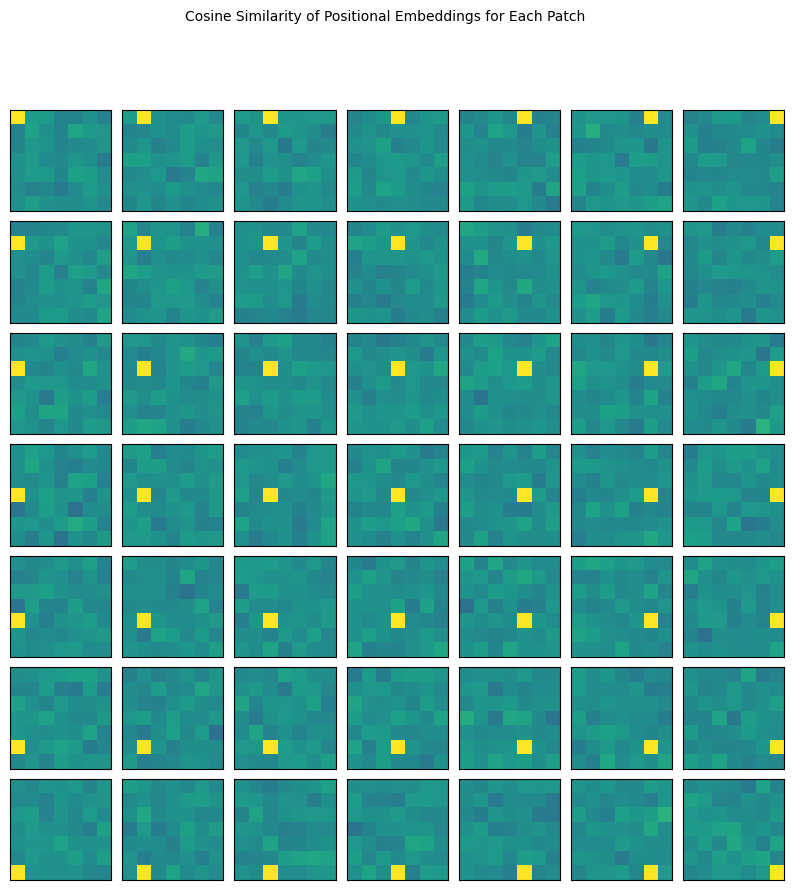

In [64]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity

positional_embd = model.state_dict()["vit.positional_embd"]
positional_embd = positional_embd[0, 1:].detach().cpu().numpy()

num_patches = positional_embd.shape[0]
grid_size = int(np.sqrt(num_patches))

cos_sim_matrix = cosine_similarity(positional_embd)

fig, axes = plt.subplots(grid_size, grid_size, figsize=(10, 10))

for i in range(grid_size):
    for j in range(grid_size):
        patch_index = i * grid_size + j
        similarity = cos_sim_matrix[patch_index].reshape(grid_size, grid_size)
        ax = axes[i, j]
        im = ax.imshow(similarity, cmap='viridis', vmin=-1, vmax=1)
        ax.set_xticks([])
        ax.set_yticks([])

# fig.colorbar(im, ax=axes.ravel().tolist(), shrink=0.5, label="Cosine Similarity")
plt.suptitle("Cosine Similarity of Positional Embeddings for Each Patch", fontsize=10)
plt.subplots_adjust(wspace=0.1, hspace=0.1)
plt.show()


# viz attn map
https://github.com/huggingface/pytorch-image-models/discussions/1232
- https://arxiv.org/pdf/2005.00928


## attention map
Attention(Q, K) = softmax(QK^T / sqrt(d_k))
this is the attention weight. (seq_len, seq_len) for me (50,50).

##


In [140]:
attention_maps = []
batch = next(iter(val_loader))
images, labels = batch["image"], batch["label"]
model.eval()
print(model(torch.rand((1,1,28,28)).to(device)).max(1), labels[0])
print(f"Number of attention maps (layers): {len(attention_maps)}")
print(f"Shape of attention map for one layer: {attention_maps[0].shape}")


torch.return_types.max(
values=tensor([3.7377], grad_fn=<MaxBackward0>),
indices=tensor([8])) tensor(8)
Number of attention maps (layers): 8
Shape of attention map for one layer: torch.Size([1, 8, 50, 50])


torch.Size([8, 50, 50])


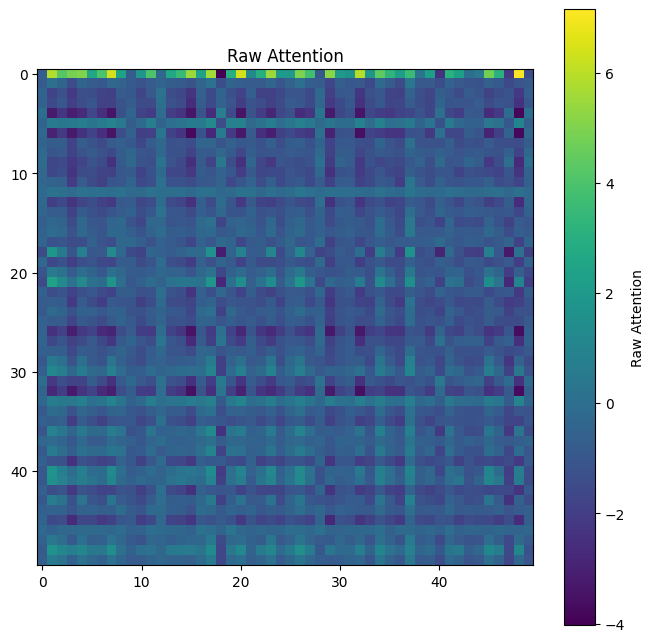

In [141]:
import torch
import numpy as np
import matplotlib.pyplot as plt

attention_map = attention_maps[0]
attention_map = attention_map.squeeze(0)
print(attention_map.shape)
# Visualize
plt.figure(figsize=(8, 8))
plt.imshow(attention_map[0], cmap="viridis")
plt.colorbar(label="Raw Attention")
plt.title("Raw Attention")
plt.show()


after avg torch.Size([8, 1, 50, 50])
roll out torch.Size([1, 50, 50])
roll out after recursive matmul torch.Size([1, 50, 50])


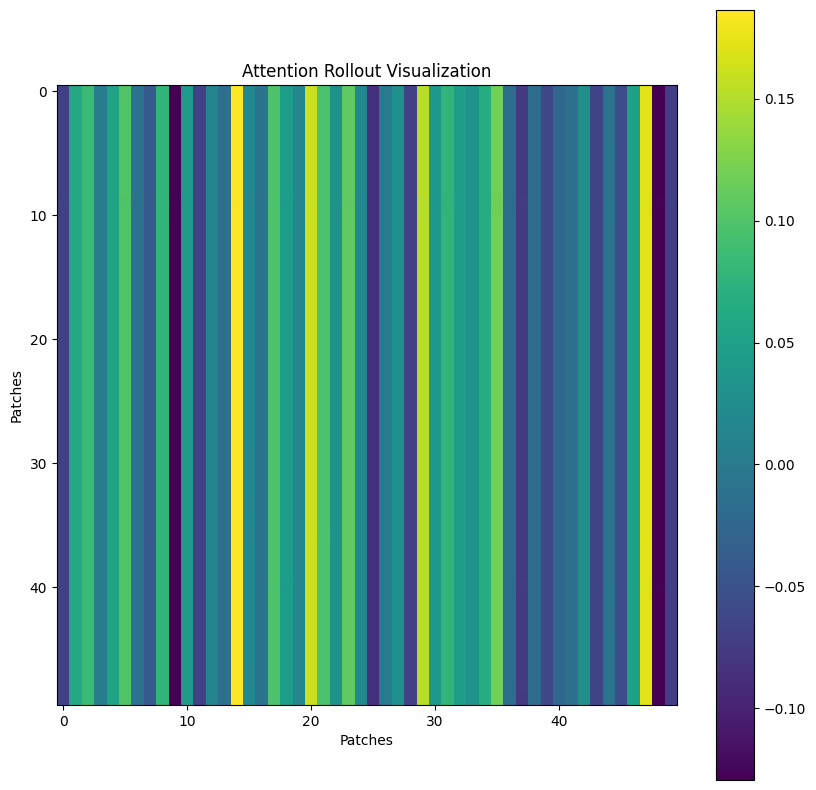

In [142]:
attentions = torch.stack(attention_maps)
import torch
import matplotlib.pyplot as plt

# Assuming `attentions` has shape (num_layers, batch_size, n_heads, num_patches, num_patches)
num_layers, batch_size, n_heads, num_patches, _ = attentions.shape

# Average over heads: (num_layers, batch_size, n_heads, num_patches, num_patches) -> (num_layers, batch_size, num_patches, num_patches)
average_attentions = attentions.mean(dim=2)
print(f"after avg {average_attentions.shape}")

# Initialize rollout attention with identity matrix
rollout_attention = torch.eye(num_patches).unsqueeze(0).repeat(batch_size, 1, 1)
print(f"roll out {rollout_attention.shape}")
# Compute attention rollout
for layer_attention in average_attentions:
    # Add residual connection
    layer_attention = layer_attention + torch.eye(num_patches).unsqueeze(0)
    layer_attention = layer_attention / layer_attention.sum(dim=-1, keepdim=True)  # Normalize rows
    rollout_attention = torch.matmul(rollout_attention, layer_attention)
print(f"roll out after recursive matmul {rollout_attention.shape}")

# Visualize the attention for the CLS token to input patches (assuming CLS token is at index 0)
cls_attention = rollout_attention[0, :, :]  # Exclude CLS itself

# Plot attention for the first sample in the batch
plt.figure(figsize=(10, 10))
plt.imshow(cls_attention.detach().cpu().numpy(), cmap="viridis")
plt.colorbar()
plt.title("Attention Rollout Visualization")
plt.xlabel("Patches")
plt.ylabel("Patches")
plt.show()


cls torch.Size([50, 50])


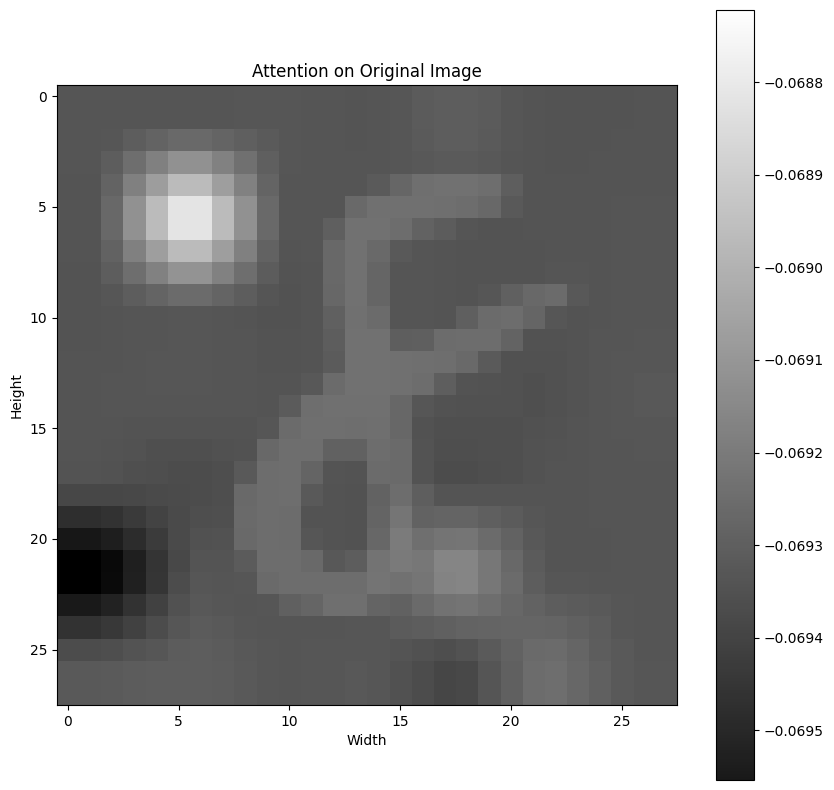

In [143]:
import torch
import matplotlib.pyplot as plt
from torchvision.transforms.functional import resize

# Assuming the input image has dimensions (H, W) and patch_size is known
input_resolution = (28, 28)  # Replace with your actual input image resolution
patch_size = 4  # Patch size used in ViT
grid_size = (input_resolution[0] // patch_size, input_resolution[1] // patch_size)

print(f"cls {cls_attention.shape}")

# Reshape attention into the patch grid
cls_attention_grid = rollout_attention[0,1:, 0].view(grid_size)

# Upsample to input resolution
from PIL import Image
import torchvision.transforms as transforms

import torchvision.transforms as transforms

transform = transforms.Resize((28, 28), interpolation=Image.BILINEAR)
transformed = transform(cls_attention_grid.unsqueeze(0)).squeeze(0).squeeze().detach().cpu().numpy()

# Visualize attention overlaid on the original image
plt.figure(figsize=(10, 10))
plt.imshow(images[0].squeeze().detach().cpu().numpy(), cmap="gray")
plt.imshow(transformed, cmap='gray', alpha=0.9)
plt.colorbar()
plt.title("Attention on Original Image")
plt.xlabel("Width")
plt.ylabel("Height")
plt.show()
